In [1]:
import anndata
import scvelo as scv
import scvi
import numpy as np
from velovi import preprocess_data, VELOVI
import torch
import os
import argparse
import time

/scratch/blaauw_root/blaauw1/gyichen/velovi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Global seed set to 0


In [2]:
root = '/scratch/blaauw_root/blaauw1/gyichen'
dataset = 'Hindbrain_pons'
adata = anndata.read_h5ad(f'{root}/data/{dataset}_pp.h5ad')

In [3]:
start = time.time()
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
torch.set_float32_matmul_precision('highest')
vae = VELOVI(adata)
scvi.settings.seed=2022
vae.train(max_epochs=500, use_gpu='cuda:0', train_size=0.7)
run_time = time.time() - start

[rank: 0] Global seed set to 2022
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [03:19<00:00,  2.54it/s, loss=-3.74e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [03:19<00:00,  2.50it/s, loss=-3.74e+03, v_num=1]


# Save all results to a .h5ad file
Referecne: https://velovi.readthedocs.io/en/latest/tutorial.html

In [4]:
def add_velovi_outputs_to_adata(adata, vae, num_samples=25):
    vae.module = vae.module.to(torch.device('cpu'))
    latent_time = vae.get_latent_time(n_samples=num_samples)
    velocities = vae.get_velocity(n_samples=num_samples, velo_statistic="mean")
    
    
    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velovi_velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time
    
    adata.var["velovi_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["velovi_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["velovi_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["velovi_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['velovi_scaling'] = 1.0

    shat, uhat = vae.get_expression_fit(adata, n_samples=num_samples, return_mean=True)
    likelihood = vae.get_gene_likelihood(adata, n_samples=num_samples, return_mean=True)
    adata.layers["velovi_uhat"] = uhat
    adata.layers["velovi_shat"] = shat
    adata.obs["velovi_likelihood"] = likelihood.sum(1)
    adata.var["fit_likelihood"] = likelihood.mean(0)

    scv.tl.velocity_graph(adata, vkey="velovi_velocity")
    scv.tl.latent_time(adata, vkey="velovi_velocity")
    adata.obs['velovi_time'] = adata.obs['latent_time'].to_numpy()
    del adata.obs['latent_time']
    
    random_state = np.random.RandomState(seed=0)
    permutation = random_state.permutation(adata.n_obs)
    n_val = int(np.floor(adata.n_obs * 0.3))
    adata.uns['velovi_test_idx'] = permutation[:n_val]
    adata.uns['velovi_train_idx'] = permutation[n_val:]
    adata.uns['velovi_run_time'] = run_time

In [5]:
add_velovi_outputs_to_adata(adata, vae)
adata.write_h5ad(f'{root}/data/velovi/{dataset}/{dataset}.h5ad')

computing velocity graph (using 1/32 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:01:15) --> added 
    'velovi_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 4 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:04) --> added 
    'latent_time', shared time (adata.obs)


# Plotting

In [2]:
root = '/scratch/blaauw_root/blaauw1/gyichen'
dataset = 'Hindbrain_pons'
adata = anndata.read_h5ad(f'{root}/data/velovi/{dataset}/{dataset}_post.h5ad')

saving figure to file /scratch/blaauw_root/blaauw1/gyichen/data/velovi/Hindbrain_pons/velovi_stream.png


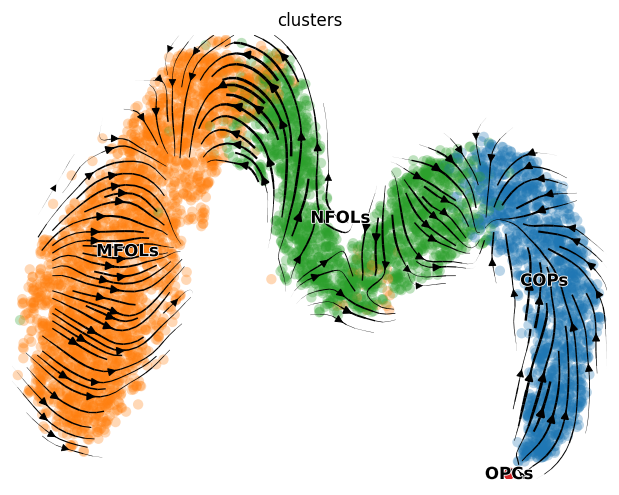

In [3]:
scv.pl.velocity_embedding_stream(adata, vkey='velovi_velocity', dpi=120, save=f'{root}/data/velovi/{dataset}/velovi_stream.png')

saving figure to file /scratch/blaauw_root/blaauw1/gyichen/data/velovi/Hindbrain_pons/velovi_time.png


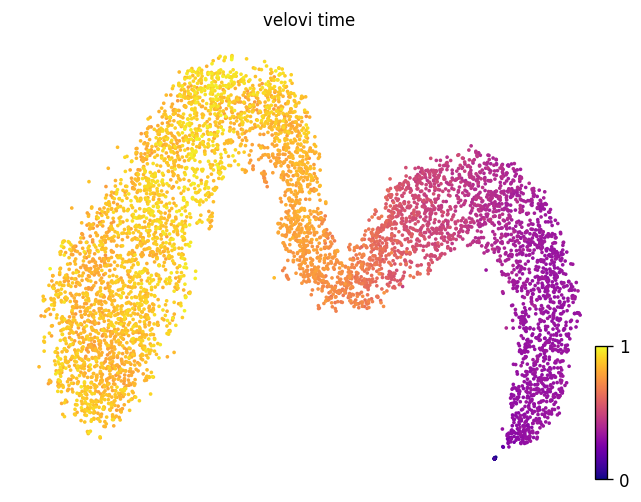

In [4]:
scv.pl.scatter(adata, color='velovi_time', color_map='plasma', dpi=120, save=f'{root}/data/velovi/{dataset}/velovi_time.png')